In [2]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
from collections import OrderedDict
from scipy import signal
import glob
from scipy import linalg
import six
from sigutils import log_bins
from munch import Munch
from decorator import decorator
from kpfm.util import h5filename
    
@h5filename
def psd_CPD(fh, window='boxcar'):
    CPD = fh['CPD'][:]
    fs = fh.attrs['Inputs.Scan rate [Hz]']
    N = fh.attrs['Inputs.N traces']
    freq, psd = signal.periodogram(CPD, fs, window=window)
    return Munch(freq=freq, psd=psd, CPD=CPD, fs=fs)

def map_ordered(od, f, *args, **kwargs):
    return OrderedDict((key, f(val, *args, **kwargs)) for (key, val) in od.items())

def plot_PSD(od, r):
    fig, ax = plt.subplots()
    i = len(od)
    for key, val in od.items():
        val.freq_log, val.psd_log = log_bins(val.freq[1:], val.psd[1:], r)
        if key == 4:
            alpha = 0.5
        else:
            alpha = 1
        ax.loglog(val.freq_log, val.psd_log*1e6, alpha=alpha, label="{} V".format(key), zorder=i)
        i = i - 1
    
    return fig, ax

In [3]:
files = OrderedDict([
  (0.5, '../data/KPFM-linescans/170224-1703DPh-BTBT-p5V-trace-retrace.h5'),
  (1.0,  '../data/KPFM-linescans/170224-1658DPh-BTBT-1V-trace-retrace.h5'),
  (2.0,  '../data/KPFM-linescans/170224-1653DPh-BTBT-2V-stationary.h5'),
#   (0.25, '../data/KPFM-linescans/170224-1724DPh-BTBT-p25V-trace-retrace.h5'),
#   (0.125, '../data/KPFM-linescans/170224-1733DPh-BTBT-p126V-trace-retrace.h5'),
  (3.0, '../data/KPFM-linescans/170224-1738DPh-BTBT-40V-trace-retrace.h5')
])
psds = map_ordered(files, lambda x: psd_CPD(x, 'blackman'))

In [4]:
plt.rc('font', size=9)
plt.rc('figure', figsize=(3.25, 2.75))

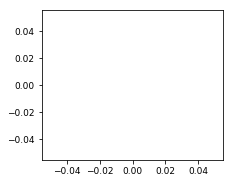

In [5]:
colors = [plt.plot(0, 0)[0].get_color() for i in xrange(5)]

0.5


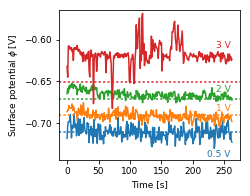

In [8]:
fig = plt.figure(figsize=(3.25, 2.75))
i = 0
dphi= 0.02
for key, fname in files.items():
    d = psd_CPD(fname)
    if i == 0:
        print(key)
        phi0 = np.mean(d['CPD'][::1000])
    line, = plt.plot(d['CPD'][::1000] + i * dphi, label="{} V".format(key))
    plt.axhline(phi0 + i * dphi, color=line.get_color(), linestyle=":")
    i += 1

pos = [(237, -0.61, "3 V"),
 (237, -0.662, "2 V"),
(237, -0.685, "1 V"),
(223, -0.74, "0.5 V")]
for posxy, color in zip(reversed(pos), colors):
    plt.text(*posxy, color=color )

plt.ylim(-0.744, -0.565)
plt.yticks([-0.7, -0.65, -0.6])
plt.xlabel("Time [s]")
plt.ylabel("Surface potential $\phi$ [V]")
fig.savefig("../figs/103a-potential-noise-time.pdf", bbox_inches='tight')

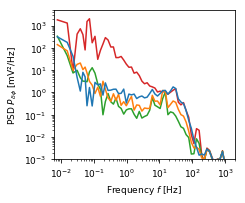

In [11]:
fig, axes = plot_PSD(psds, r=1.2)
axes.set_ylim(1e-3, 5e3)
axes.set_xlim(6e-3, 2e3)
axes.set_xlabel("Frequency $f$ [Hz]")
axes.set_ylabel(u"PSD $P_{\delta \phi}$ [mV²/Hz]")
fig.savefig("../figs/103b-potential-noise-psd.pdf", bbox_inches='tight')